## История изменений



#### Базовый эксперимент

1. Что сделано.
  
  - Загружен датасет GSM8K

  - Проведено обучение qwen2.5-0.5B на датасете GSM8K-main на трех эпохах

2. Полученные результаты

  - Обученная модель с данными лоссов на обучающей выборке

3. Выводы

  - Предельное значение количества параметров - 500M, так как даже для обучения qwen2.5-0.5B на датасете 3 тысячах объектов GSM8K-main понадобилось 10 GB GPU и нельзя было использовать `batch_size > 3`.

  - Обучение больших моделей на сравнительно небольшом объеме данных занимает до часу времени. (личный вывод)


4. Чему научился

  - Пользоваться интерфейсом HuggingFace

  - Библиотека transformer, datasetы

  - Лучше изучил задачу text generation





#### Вычислительный эксперимент: обучение Qwen lora_r = 8

1. Что сделано.
  
  - Настроен пайплайн обучения через trl, использование SPIN

  - Обучена модель Qwen2.5-0.5B с `lora_r = 8`, на двух итерациях метода SPIN.

2. Полученные результаты

  - Обученная модель с данными лоссов на обучающей выборке


## Библиотеки

В этой секции будут описаны базовые библиотеки, используемые практически для всех экспериментов.

In [ ]:
! pip install transformers peft
! pip install datasets trl hf-xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
# basic libraries
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
from torchsummary import summary

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    DataCollatorForSeq2Seq,
)

from datasets import load_dataset, Dataset

from peft import LoraConfig, PeftModel, get_peft_model

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


-----------------
## Датасеты

На данный момент используются датасеты:

- gsm8k: main и socratic

- ultrachat_200k: train_sft и test_sft

In [ ]:
datasets = {}

In [ ]:
datasets['gsm_main'] = load_dataset("openai/gsm8k", "main")
datasets['gsm_socratic'] = load_dataset("openai/gsm8k", "socratic")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/487k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
datasets['uchat_train'] = load_dataset("HuggingFaceH4/ultrachat_200k", split='train_sft[:1%]')
datasets['uchat_test'] = load_dataset("HuggingFaceH4/ultrachat_200k", split='test_sft[:1%]')

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

(…)-00000-of-00003-a3ecf92756993583.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-0a1804bcb6ae68c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00002-of-00003-ee46ed25cfae92c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00000-of-00001-f7dfac4afe5b93f4.parquet:   0%|          | 0.00/81.2M [00:00<?, ?B/s]

(…)-00000-of-00003-a6c9fb894be3e50b.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-d6a0402e417f35ca.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00002-of-00003-c0db75b92a2f48fd.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00000-of-00001-3d4cd8309148a71f.parquet:   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

--------------

## Обучение моделей
---------------

### Text generation

#### Qwen 2.5-0.5B only LoRA

Обучим модель Qwen2.5-0.5B, используя только адаптеры LoRA для получения бейзлайна

In [ ]:
# Подгружаем токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B").to(device)

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

Теперь поработаем с данными, а именно нужно токенизировать и провести padding

In [ ]:
datasets['gsm_main']['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [ ]:
next(iter(datasets['gsm_main']['train']))

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [ ]:
max_length = 0
for text in datasets['gsm_main']['train']['question']:
    max_length = max(max_length, len(text))
tokenizer.model_max_length = max_length

Так как Qwen2.5-0.5B использует примерно 2.1 Gb памяти и оставшейся памяти не хватает для обучения, то сократим размер датасета вдвое.

In [ ]:
# Преобразование данных
def format_row_qwen_gsm(elem, tokenizer):
    messages = [{"role": "user", "content": elem['question']}]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True
    ).to(device)

    answer_ids = tokenizer(
        elem['answer'],
        return_tensors="pt",
        padding="max_length",
        truncation=True
    )['input_ids'].to(device)
    inputs['labels'] = answer_ids[0]
    inputs['input_ids'] = inputs['input_ids'][0]
    inputs['attention_mask'] = inputs['attention_mask'][0]

    return inputs

def format_dataset_qwen_gsm(dataset, tokenizer):
    return dataset.map(lambda elem: format_row_qwen_gsm(elem, tokenizer))


# Ограничение датасетов
train_size = 3000
test_size = 1000
train_dataset = Dataset.from_dict(datasets['gsm_main']['train'][:train_size])
val_dataset = Dataset.from_dict(datasets['gsm_main']['test'][:train_size])

# Токенизация
train_dataset = format_dataset_qwen_gsm(train_dataset, tokenizer)
val_dataset = format_dataset_qwen_gsm(val_dataset, tokenizer)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
train_dataset = train_dataset.remove_columns(['question', 'answer'])
val_dataset = val_dataset.remove_columns(['question', 'answer'])

In [ ]:
# настройка параметров Лоры
lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "k_proj", "v_proj"]
    )

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 737,280 || all params: 494,770,048 || trainable%: 0.1490


In [ ]:
account = "MuQianyu"
peft_model_id = f"{account}/qwen2.5-0.5B_only_lora"
batch_size = 2

args = TrainingArguments(
    peft_model_id,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    logging_steps=10,
    label_names=["answer_ids"],
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

<ipython-input-15-b3f53e6d1164>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mu_qianyu (mu_qianyu-mipt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.769000,No log
2,0.906200,No log


TrainOutput(global_step=3000, training_loss=1.1117058957417807, metrics={'train_runtime': 5989.6674, 'train_samples_per_second': 1.002, 'train_steps_per_second': 0.501, 'total_flos': 1.271721100032e+16, 'train_loss': 1.1117058957417807, 'epoch': 2.0})

Попробуем обучить еще на одной эпохе

In [ ]:
args = TrainingArguments(
    peft_model_id,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    logging_steps=10,
    label_names=["answer_ids"],
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

<ipython-input-16-da16a88a45a4>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.737700,No log


TrainOutput(global_step=1500, training_loss=0.7162192662556967, metrics={'train_runtime': 2965.7117, 'train_samples_per_second': 1.012, 'train_steps_per_second': 0.506, 'total_flos': 6358605500160000.0, 'train_loss': 0.7162192662556967, 'epoch': 1.0})

In [ ]:
model.save_pretrained('qwen2.5-5b__gsm__only_lora', from_pt=True)

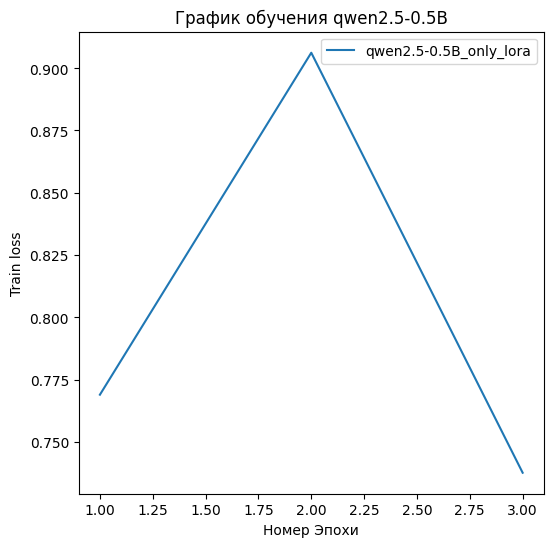

In [ ]:
import matplotlib.pyplot as plt
results = [0.769000, 0.906200, 0.737700]

plt.figure(figsize=(6, 6))
plt.title('График обучения qwen2.5-0.5B')
plt.xlabel('Номер Эпохи')
plt.ylabel('Train loss')
plt.plot(np.arange(1, 4), results, label='qwen2.5-0.5B_only_lora')

plt.legend()
plt.show()

In [ ]:
def color_map_color(value, cmap_name='YlOrRd', vmin=8, vmax=15):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

<ipython-input-48-b1fd6ab1578b>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)  # PiYG


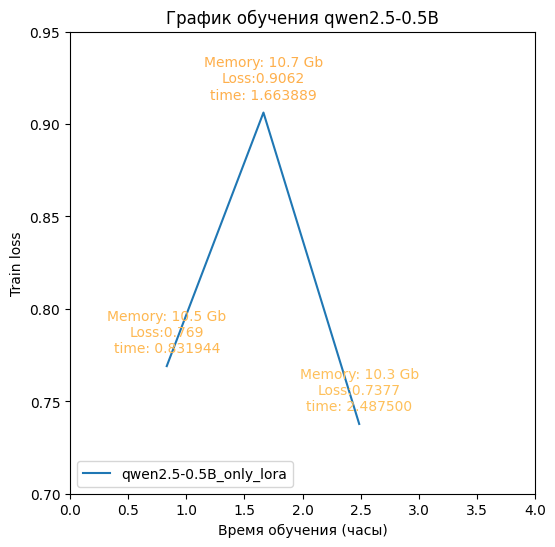

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
results = [0.769000, 0.906200, 0.737700]
train_time = np.array([2995, 5990, 8955]) / 3600
memory_usage = [10.5, 10.7, 10.3]

plt.figure(figsize=(6, 6))
plt.title('График обучения qwen2.5-0.5B')
plt.xlabel('Время обучения (часы)')
plt.ylabel('Train loss')
plt.ylim([0.7, 0.95])
plt.xlim([0, 4])
plt.plot(train_time, results, label='qwen2.5-0.5B_only_lora')

for result, time, memory in zip(results, train_time, memory_usage):
    plt.annotate(
        f'Memory: {memory} Gb\nLoss:{result}\ntime: {time:2f}',
        (time, result),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=10,
        color=color_map_color(memory)
    )


plt.legend()
plt.show()

#### Qwen 2.5-0.5B - Instruct only LoRA


Загружаем модель и токенайзер

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Внедряем адаптеры LoRA

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Проверяем, сколько параметров обучается

trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


Теперь займемся обработкой датасета ultrachat_200k. Во-первых необходимо уменьшить размер

In [ ]:
def format_chat(example):
    messages = example["messages"]
    text = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": text}

train_dataset = datasets['uchat_train'].map(format_chat, remove_columns=["messages"])
test_dataset = datasets['uchat_test'].map(format_chat, remove_columns=["messages"])

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

In [ ]:
tokenized_response = tokenizer.encode('<|im_start|>assistant\n')
collator = DataCollatorForCompletionOnlyLM(
    # явно указываем начало assistant-реплики, до нее включительно будет стоять -100 для подсчет Cross-Entropy
    response_template=tokenized_response,
    tokenizer=tokenizer,
    return_tensors="pt"
)

In [ ]:
training_args = SFTConfig(
    output_dir="./qwen2_0.5B_instruct_sft",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=1000,
    eval_strategy="steps",
    eval_steps=300,
    bf16=True,
    optim="adamw_torch",
    report_to="tensorboard",
    dataset_text_field="text"
)

trainer = SFTTrainer(
    model.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collator,
    peft_config=lora_config
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
300,1.300800,1.283360
600,1.256400,1.282033
900,1.229100,1.281065
1200,1.273300,1.280703
1500,1.247000,1.280840


TrainOutput(global_step=1560, training_loss=1.2710570897811497, metrics={'train_runtime': 7902.7638, 'train_samples_per_second': 0.789, 'train_steps_per_second': 0.197, 'total_flos': 1.3244808366163968e+16, 'train_loss': 1.2710570897811497})

Пиковое значение использования GPU составляет 13.9 Gb

In [ ]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = PeftModel.from_pretrained(
    model=model,
    model_id='./qwen2_0.5B_instruct_sft/checkpoint-1560',
    peft_config=lora_config,
    is_trainable=True
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

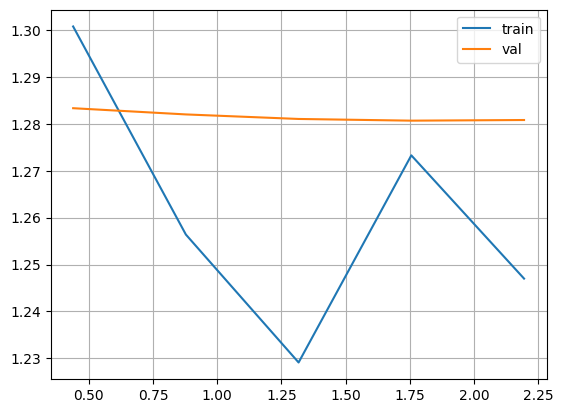

In [ ]:
plt.grid()
plt.plot(train_time, train_loss, label='train')
plt.plot(train_time, val_loss, label='val')
plt.legend()
plt.show()

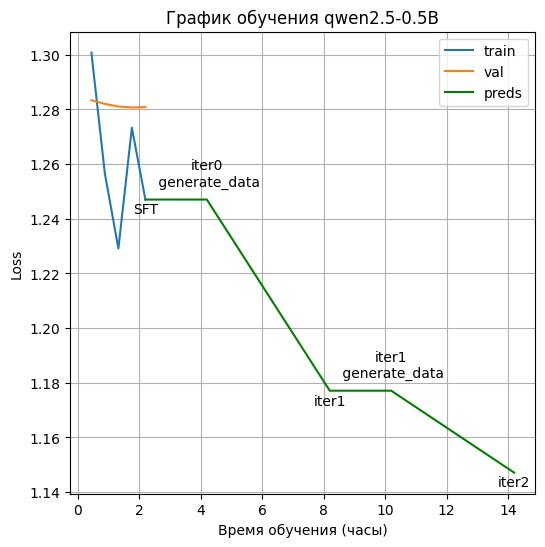

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
train_loss = [1.300800, 1.256400, 1.229100, 1.273300, 1.247000]
val_loss = [1.283360, 1.282033, 1.281065, 1.280703, 1.280840]
train_time = np.cumsum(np.ones(5) * 7902.7638 / 5 / 3600)
memory_usage = np.ones(5) * 13.9
plt.figure(figsize=(6, 6))
plt.title('График обучения qwen2.5-0.5B')
plt.xlabel('Время обучения (часы)')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(train_time, train_loss, label='train')
plt.plot(train_time, val_loss, label='val')

theory_time = np.array([0, 2, 6, 8, 12]) + train_time[-1]
theory_loss = np.array([0, 0, -0.07, -0.07, -0.1]) + train_loss[-1]
plt.plot(theory_time, theory_loss, color='g', label='preds')

plt.annotate('SFT', (train_time[-1], train_loss[-1]), textcoords="offset points", xytext=(0,-10), ha='center')
plt.annotate('iter0\n generate_data', (theory_time[1], theory_loss[1]), textcoords="offset points", xytext=(0,10), ha='center',)
plt.annotate('iter1', (theory_time[2], theory_loss[2]), textcoords="offset points", xytext=(0,-10), ha='center',)
plt.annotate('iter1\n generate_data', (theory_time[3], theory_loss[3]), textcoords="offset points", xytext=(0,10), ha='center',)
plt.annotate('iter2', (theory_time[4], theory_loss[4]), textcoords="offset points", xytext=(0,-10), ha='center',)

plt.legend()
plt.show()

#### SPIN

In [ ]:
! git clone https://github.com/uclaml/SPIN.git
! python -m pip install SPIN/

Cloning into 'SPIN'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 603 (delta 140), reused 127 (delta 122), pack-reused 438 (from 1)
Receiving objects: 100% (603/603), 3.58 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (358/358), done.


Преобразуем датасет ultrachat_200k в удобный шаблон для Instruct модели, также вставив место для сгененированного ответа

In [ ]:
! python SPIN/spin/reformat.py





Extracting data files: 100% 4/4 [00:00<00:00, 1131.46it/s]
Generating train_sft split: 100% 207865/207865 [00:05<00:00, 38459.63 examples/s]
Generating test_sft split: 100% 23110/23110 [00:00<00:00, 41475.09 examples/s]
Generating train_gen split: 100% 256032/256032 [00:04<00:00, 52883.09 examples/s]
Generating test_gen split: 100% 28304/28304 [00:00<00:00, 53504.58 examples/s]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Extracting data files: 100% 1/1 [00:00<00:00, 1947.22it/s]
Generating train split: 207865 examples [00:08, 23839.88 examples/s]
Extracting data files: 100% 1/1 [00:00<00:00, 2011.66it/s]
Generating train split: 23110 examples [00:00, 34818.87 examples/s]


##### Qwen 2.5-0.5B iter1

Сгенерируем ответы на элементы датасета для тренировочной выборки

In [ ]:
# reference: https://medium.com/@geronimo7/llms-multi-gpu-inference-with-accelerate-5a8333e4c5db

from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import argparse
import torch, time, json, os
from pathlib import Path
from tqdm import tqdm
from datetime import timedelta
from accelerate.utils import InitProcessGroupKwargs

import warnings
warnings.filterwarnings("ignore")

kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=36000))
accelerator = Accelerator(kwargs_handlers=[kwargs])

def parse_arguments():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='UCLA-AGI/zephyr-7b-sft-full-SPIN-iter0')
    parser.add_argument('--data_frac', type=int, default=0)
    parser.add_argument('--frac_len', type=int, default=0)
    parser.add_argument('--output_dir', type=str, default='generated/iter1')
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--input_dir', type=str, default='UCLA-AGI/SPIN_iter0')
    parser.add_argument('--split', type=str, default='train')
    return parser.parse_args()

def prepare_prompts(prompts, tokenizer, batch_size=4):
    """Prepare prompts for tokenization."""
    batches=[prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]
    batches_tok=[]
    tokenizer.padding_side="left"
    for prompt_batch in batches:
        batches_tok.append(
            tokenizer(
                prompt_batch,
                return_tensors="pt",
                padding='longest',
                truncation=False,
                pad_to_multiple_of=8,
                add_special_tokens=False).to("cuda")
            )
    tokenizer.padding_side="right"
    return batches_tok

def main():
    model_path = 'qwen2_0.5B_instruct_model_sft'
    data_frac = 0
    frac_len = 0
    batch_size = 4
    output_dir = 'test'
    split = 'train'

    # load a base model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map={"": accelerator.process_index},
        torch_dtype=torch.bfloat16,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    # load data
    data = load_dataset('reformatted', split=split + '[:1%]')
    data = data.shuffle(seed=42)
    if frac_len > 0:
        sub_len = frac_len
        if sub_len*(data_frac+1) > len(data):
            data = data[sub_len*data_frac:]['real']
        else:
            data = data[sub_len*data_frac:sub_len*(data_frac+1)]['real']
    else:
        data = data[:]['real']

    prompts_all = ["### Instruction: " + data[idx][0]['content'] + "\n\n### Response: " for idx in range(len(data))]
    prompts_old = [data[idx][0]['content'] for idx in range(len(data))]
    corrects_all = [data[idx][1]['content'] for idx in range(len(data))]

    # sync GPUs and start the timer
    accelerator.wait_for_everyone()
    start=time.time()

    # divide the prompt list onto the available GPUs
    with accelerator.split_between_processes(prompts_all) as prompts:
        results = []
        prompt_batches=prepare_prompts(prompts, tokenizer, batch_size=batch_size)

        for prompts_tokenized in tqdm(prompt_batches):
            # set max_new_tokens smaller for faster inference
            outputs_tokenized=model.generate(**prompts_tokenized, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)

            # remove prompt from gen. tokens
            outputs_tokenized=[ tok_out[len(tok_in):]
                for tok_in, tok_out in zip(prompts_tokenized["input_ids"], outputs_tokenized) ]
            # decode gen. tokens
            outputs=tokenizer.batch_decode(outputs_tokenized)
            results.extend(outputs)

    # collect results from all the GPUs and remove paddings
    results_gathered=gather_object(results)
    results = [r.replace("</s>","").lstrip() for r in results_gathered]

    if accelerator.is_local_main_process:
        timediff=time.time()-start
        print(f"time elapsed: {timediff}")

        # collecting data
        for idx in range(len(corrects_all)):
            d = {"real": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": corrects_all[idx]}], "generated": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": results[idx]}]}
            if split == 'test':
                filename = f"{output_dir}/loser_{data_frac}_test.jsonl"
            else:
                filename = f"{output_dir}/loser_{data_frac}.jsonl"
            with open(filename, 'a') as f:
                json.dump(d, f)
                f.write('\n')


if __name__ == "__main__":
    main()

RuntimeError: Failed to import transformers.models.aria.configuration_aria because of the following error (look up to see its traceback):
No module named 'transformers.models.aria.configuration_aria'

Теперь для валидационной выборки

In [ ]:
# reference: https://medium.com/@geronimo7/llms-multi-gpu-inference-with-accelerate-5a8333e4c5db

from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import argparse
import torch, time, json, os
from pathlib import Path
from tqdm import tqdm
from datetime import timedelta
from accelerate.utils import InitProcessGroupKwargs

import warnings
warnings.filterwarnings("ignore")

kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=36000))
accelerator = Accelerator(kwargs_handlers=[kwargs])

def parse_arguments():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='UCLA-AGI/zephyr-7b-sft-full-SPIN-iter0')
    parser.add_argument('--data_frac', type=int, default=0)
    parser.add_argument('--frac_len', type=int, default=0)
    parser.add_argument('--output_dir', type=str, default='generated/iter1')
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--input_dir', type=str, default='UCLA-AGI/SPIN_iter0')
    parser.add_argument('--split', type=str, default='train')
    return parser.parse_args()

def prepare_prompts(prompts, tokenizer, batch_size=4):
    """Prepare prompts for tokenization."""
    batches=[prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]
    batches_tok=[]
    tokenizer.padding_side="left"
    for prompt_batch in batches:
        batches_tok.append(
            tokenizer(
                prompt_batch,
                return_tensors="pt",
                padding='longest',
                truncation=False,
                pad_to_multiple_of=8,
                add_special_tokens=False).to("cuda")
            )
    tokenizer.padding_side="right"
    return batches_tok

def main():
    model_path = 'qwen2_0.5B_instruct_model_sft'
    data_frac = 0
    frac_len = 0
    batch_size = 4
    output_dir = 'qwen_generated/iter0'
    split = 'test'

    # load a base model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map={"": accelerator.process_index},
        torch_dtype=torch.bfloat16,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    # load data
    data = load_dataset('reformatted', split=split + '[:1%]')
    data = data.shuffle(seed=42)
    if frac_len > 0:
        sub_len = frac_len
        if sub_len*(data_frac+1) > len(data):
            data = data[sub_len*data_frac:]['real']
        else:
            data = data[sub_len*data_frac:sub_len*(data_frac+1)]['real']
    else:
        data = data[:]['real']

    prompts_all = ["### Instruction: " + data[idx][0]['content'] + "\n\n### Response: " for idx in range(len(data))]
    prompts_old = [data[idx][0]['content'] for idx in range(len(data))]
    corrects_all = [data[idx][1]['content'] for idx in range(len(data))]

    # sync GPUs and start the timer
    accelerator.wait_for_everyone()
    start=time.time()

    # divide the prompt list onto the available GPUs
    with accelerator.split_between_processes(prompts_all) as prompts:
        results = []
        prompt_batches=prepare_prompts(prompts, tokenizer, batch_size=batch_size)

        for prompts_tokenized in tqdm(prompt_batches):
            # set max_new_tokens smaller for faster inference
            outputs_tokenized=model.generate(**prompts_tokenized, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)

            # remove prompt from gen. tokens
            outputs_tokenized=[ tok_out[len(tok_in):]
                for tok_in, tok_out in zip(prompts_tokenized["input_ids"], outputs_tokenized) ]
            # decode gen. tokens
            outputs=tokenizer.batch_decode(outputs_tokenized)
            results.extend(outputs)

    # collect results from all the GPUs and remove paddings
    results_gathered=gather_object(results)
    results = [r.replace("</s>","").lstrip() for r in results_gathered]

    if accelerator.is_local_main_process:
        timediff=time.time()-start
        print(f"time elapsed: {timediff}")

        # collecting data
        for idx in range(len(corrects_all)):
            d = {"real": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": corrects_all[idx]}], "generated": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": results[idx]}]}
            if split == 'test':
                filename = f"{output_dir}/loser_{data_frac}_test.jsonl"
            else:
                filename = f"{output_dir}/loser_{data_frac}.jsonl"
            with open(filename, 'a') as f:
                json.dump(d, f)
                f.write('\n')


if __name__ == "__main__":
    main()

100%|██████████| 58/58 [13:27<00:00, 13.93s/it]

time elapsed: 808.0595595836639


Теперь соберем разрозненные части сгенерированного датасета в `.parquet`.

In [ ]:
! mkdir qwen_datasets/iter0
! python3 SPIN/spin/convert_data.py --num_fracs=3 --input_dir=qwen_generated/iter0 --output_dir=qwen_datasets/iter0

2079
231
Extracting data files: 100% 1/1 [00:00<00:00, 1230.36it/s]
Generating train split: 2079 examples [00:00, 14534.38 examples/s]
Extracting data files: 100% 1/1 [00:00<00:00, 1673.04it/s]
Generating train split: 231 examples [00:00, 21048.97 examples/s]
2079
231


Приступим ко второму этапу метода SPIN - обучение модели.
Необходима более старая версия numpy

In [ ]:
! pip install numpy==1.26.4
! python3 SPIN/spin/run_spin.py config.yaml

Выходные данные были обрезаны до нескольких последних строк (5000).
policy_generated_logps: tensor([-456.5797], device='cuda:0', grad_fn=<SliceBackward0>)
opponent_real_logps: tensor([-601.7887], device='cuda:0')
opponent_generated_logps: tensor([-441.6421], device='cuda:0')
logits: tensor([15.2387], device='cuda:0', grad_fn=<SubBackward0>)
real_rewards: tensor([0.0301], device='cuda:0')
generated_rewards: tensor([-1.4938], device='cuda:0')
 90% 5624/6237 [1:37:55<07:58,  1.28it/s]losses: tensor([0.0213], device='cuda:0', grad_fn=<NegBackward0>)
policy_real_logps: tensor([-264.7897], device='cuda:0', grad_fn=<SliceBackward0>)
policy_generated_logps: tensor([-409.7273], device='cuda:0', grad_fn=<SliceBackward0>)
opponent_real_logps: tensor([-271.2528], device='cuda:0')
opponent_generated_logps: tensor([-377.7829], device='cuda:0')
logits: tensor([38.4075], device='cuda:0', grad_fn=<SubBackward0>)
real_rewards: tensor([0.6463], device='cuda:0')
generated_rewards: tensor([-3.1944], device

##### Qwen 2.5-0.5B iter2

In [ ]:
! cp -r ./drive/MyDrive/qwen2.5/ .

In [ ]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
! mkdir ./qwen2.5/generated/iter1

In [ ]:
# reference: https://medium.com/@geronimo7/llms-multi-gpu-inference-with-accelerate-5a8333e4c5db

from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import argparse
import torch, time, json, os
from pathlib import Path
from tqdm import tqdm
from datetime import timedelta
from accelerate.utils import InitProcessGroupKwargs

import warnings
warnings.filterwarnings("ignore")

kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=36000))
accelerator = Accelerator(kwargs_handlers=[kwargs])

def parse_arguments():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='UCLA-AGI/zephyr-7b-sft-full-SPIN-iter0')
    parser.add_argument('--data_frac', type=int, default=0)
    parser.add_argument('--frac_len', type=int, default=0)
    parser.add_argument('--output_dir', type=str, default='generated/iter1')
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--input_dir', type=str, default='UCLA-AGI/SPIN_iter0')
    parser.add_argument('--split', type=str, default='train')
    return parser.parse_args()

def prepare_prompts(prompts, tokenizer, batch_size=4):
    """Prepare prompts for tokenization."""
    batches=[prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]
    batches_tok=[]
    tokenizer.padding_side="left"
    for prompt_batch in batches:
        batches_tok.append(
            tokenizer(
                prompt_batch,
                return_tensors="pt",
                padding='longest',
                truncation=False,
                pad_to_multiple_of=8,
                add_special_tokens=False).to("cuda")
            )
    tokenizer.padding_side="right"
    return batches_tok

model_path = './qwen2.5/models/iter1'
data_frac = 0
frac_len = 0
batch_size = 4
output_dir = './qwen2.5/generated/iter1'
split = 'test'

# load a base model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map={"": accelerator.process_index},
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# load data
data = load_dataset('./qwen2.5/reformatted', split=split + '[:1%]')
data = data.shuffle(seed=42)
if frac_len > 0:
    sub_len = frac_len
    if sub_len*(data_frac+1) > len(data):
        data = data[sub_len*data_frac:]['real']
    else:
        data = data[sub_len*data_frac:sub_len*(data_frac+1)]['real']
else:
    data = data[:]['real']

prompts_all = ["### Instruction: " + data[idx][0]['content'] + "\n\n### Response: " for idx in range(len(data))]
prompts_old = [data[idx][0]['content'] for idx in range(len(data))]
corrects_all = [data[idx][1]['content'] for idx in range(len(data))]

# sync GPUs and start the timer
accelerator.wait_for_everyone()
start=time.time()

# divide the prompt list onto the available GPUs
with accelerator.split_between_processes(prompts_all) as prompts:
    results = []
    prompt_batches=prepare_prompts(prompts, tokenizer, batch_size=batch_size)

    for prompts_tokenized in tqdm(prompt_batches):
        # set max_new_tokens smaller for faster inference
        outputs_tokenized=model.generate(**prompts_tokenized, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)

        # remove prompt from gen. tokens
        outputs_tokenized=[ tok_out[len(tok_in):]
            for tok_in, tok_out in zip(prompts_tokenized["input_ids"], outputs_tokenized) ]
        # decode gen. tokens
        outputs=tokenizer.batch_decode(outputs_tokenized)
        results.extend(outputs)

# collect results from all the GPUs and remove paddings
results_gathered=gather_object(results)
results = [r.replace("</s>","").lstrip() for r in results_gathered]

if accelerator.is_local_main_process:
    timediff=time.time()-start
    print(f"time elapsed: {timediff}")

    # collecting data
    for idx in range(len(corrects_all)):
        d = {"real": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": corrects_all[idx]}], "generated": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": results[idx]}]}
        if split == 'test':
            filename = f"{output_dir}/loser_{data_frac}_test.jsonl"
        else:
            filename = f"{output_dir}/loser_{data_frac}.jsonl"
        with open(filename, 'a') as f:
            json.dump(d, f)
            f.write('\n')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 58/58 [10:58<00:00, 11.36s/it]

time elapsed: 659.0869681835175


In [ ]:
! mkdir ./qwen2.5/datasets/iter1
! python3 SPIN/spin/convert_data.py --num_fracs=5 --input_dir=./qwen2.5/generated/iter1 --output_dir=./qwen2.5/datasets/iter1

2079
231
Extracting data files: 100% 1/1 [00:00<00:00, 1257.66it/s]
Generating train split: 2079 examples [00:00, 15586.66 examples/s]
Extracting data files: 100% 1/1 [00:00<00:00, 1818.08it/s]
Generating train split: 231 examples [00:00, 22037.63 examples/s]
2079
231


Необходимо немного подкорректировать файл SPIN/spin/alignemnt/trainer.py закомментировать проверку наличия peft и wandb

In [ ]:
! pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+${CUDA}.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3523616 sha256=30bf6400bcea55f060ffeb83a46f55dd09ba99e2cc986e1d9861893a5ffafc32
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2707989 sha256=2cf4fddae407fc46d0c340a6275f17b7f401436919ccdef39811ef393d80f2a6
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully built torch-scatter torch-sparse


In [ ]:
! pip install numpy==1.26.4
! python3 SPIN/spin/run_spin.py ./qwen2.5/configs/iter1.yaml

Выходные данные были обрезаны до нескольких последних строк (5000).
policy_generated_logps: tensor([-551.9357], device='cuda:0', grad_fn=<SliceBackward0>)
opponent_real_logps: tensor([-615.1365], device='cuda:0')
opponent_generated_logps: tensor([-516.6193], device='cuda:0')
logits: tensor([26.9261], device='cuda:0', grad_fn=<SubBackward0>)
real_rewards: tensor([-0.8390], device='cuda:0')
generated_rewards: tensor([-3.5316], device='cuda:0')
 90% 5624/6237 [1:35:47<07:43,  1.32it/s]losses: tensor([0.0831], device='cuda:0', grad_fn=<NegBackward0>)
policy_real_logps: tensor([-276.7844], device='cuda:0', grad_fn=<SliceBackward0>)
policy_generated_logps: tensor([-513.9277], device='cuda:0', grad_fn=<SliceBackward0>)
opponent_real_logps: tensor([-287.3853], device='cuda:0')
opponent_generated_logps: tensor([-500.0727], device='cuda:0')
logits: tensor([24.4559], device='cuda:0', grad_fn=<SubBackward0>)
real_rewards: tensor([1.0601], device='cuda:0')
generated_rewards: tensor([-1.3855], devic

Сгенерируем датасет для итерации 2 для дальнейшей оценки качества разных итераций модели

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./qwen2.5/spin_iter2/checkpoint-6237")
model = PeftModel.from_pretrained(
    AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct"),
    './qwen2.5/spin_iter2/checkpoint-6237',
    config=lora_config
).base_model.merge_and_unload()

In [ ]:
# reference: https://medium.com/@geronimo7/llms-multi-gpu-inference-with-accelerate-5a8333e4c5db

from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import argparse
import torch, time, json, os
from pathlib import Path
from tqdm import tqdm
from datetime import timedelta
from accelerate.utils import InitProcessGroupKwargs

import warnings
warnings.filterwarnings("ignore")

kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=36000))
accelerator = Accelerator(kwargs_handlers=[kwargs])

def prepare_prompts(prompts, tokenizer, batch_size=4):
    """Prepare prompts for tokenization."""
    batches=[prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]
    batches_tok=[]
    tokenizer.padding_side="left"
    for prompt_batch in batches:
        batches_tok.append(
            tokenizer(
                prompt_batch,
                return_tensors="pt",
                padding='longest',
                truncation=False,
                pad_to_multiple_of=8,
                add_special_tokens=False).to("cuda")
            )
    tokenizer.padding_side="right"
    return batches_tok

model_path = './qwen2.5/models/iter2/checkpoint-6237'
data_frac = 0
frac_len = 0
batch_size = 4
output_dir = './qwen2.5/generated/iter2'
split = 'test'

# load a base model and tokenizer
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = PeftModel.from_pretrained(
    AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct"),
    model_path,
    config=lora_config
).base_model.merge_and_unload().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# load data
data = load_dataset('./qwen2.5/reformatted', split=split + '[:1%]')
data = data.shuffle(seed=42)
if frac_len > 0:
    sub_len = frac_len
    if sub_len*(data_frac+1) > len(data):
        data = data[sub_len*data_frac:]['real']
    else:
        data = data[sub_len*data_frac:sub_len*(data_frac+1)]['real']
else:
    data = data[:]['real']

prompts_all = ["### Instruction: " + data[idx][0]['content'] + "\n\n### Response: " for idx in range(len(data))]
prompts_old = [data[idx][0]['content'] for idx in range(len(data))]
corrects_all = [data[idx][1]['content'] for idx in range(len(data))]

# sync GPUs and start the timer
accelerator.wait_for_everyone()
start=time.time()

# divide the prompt list onto the available GPUs
with accelerator.split_between_processes(prompts_all) as prompts:
    results = []
    prompt_batches=prepare_prompts(prompts, tokenizer, batch_size=batch_size)

    for prompts_tokenized in tqdm(prompt_batches):
        # set max_new_tokens smaller for faster inference
        outputs_tokenized=model.generate(**prompts_tokenized, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)

        # remove prompt from gen. tokens
        outputs_tokenized=[ tok_out[len(tok_in):]
            for tok_in, tok_out in zip(prompts_tokenized["input_ids"], outputs_tokenized) ]
        # decode gen. tokens
        outputs=tokenizer.batch_decode(outputs_tokenized)
        results.extend(outputs)

# collect results from all the GPUs and remove paddings
results_gathered=gather_object(results)
results = [r.replace("</s>","").lstrip() for r in results_gathered]

if accelerator.is_local_main_process:
    timediff=time.time()-start
    print(f"time elapsed: {timediff}")

    # collecting data
    for idx in range(len(corrects_all)):
        d = {"real": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": corrects_all[idx]}], "generated": [{"role": "user", "content": prompts_old[idx]}, {"role": "assistant", "content": results[idx]}]}
        if split == 'test':
            filename = f"{output_dir}/loser_{data_frac}_test.jsonl"
        else:
            filename = f"{output_dir}/loser_{data_frac}.jsonl"
        with open(filename, 'a') as f:
            json.dump(d, f)
            f.write('\n')


100%|██████████| 58/58 [08:13<00:00,  8.50s/it]

time elapsed: 493.1723692417145


In [ ]:
! mkdir ./qwen2.5/datasets/iter2
! python3 SPIN/spin/convert_data.py --num_fracs=5 --input_dir=./qwen2.5/generated/iter2 --output_dir=./qwen2.5/datasets/iter2

mkdir: cannot create directory ‘./qwen2.5/datasets/iter2’: File exists
2079
231
Generating train split: 2079 examples [00:00, 16659.90 examples/s]
Generating train split: 231 examples [00:00, 18169.76 examples/s]
2079
231


In [ ]:
! ls ./drive/MyDrive/qwen2.5/datasets/

iter0  iter1  iter2


### Скорректированная версия SPINTrainer

In [ ]:
# Adapted from https://github.com/huggingface/alignment-handbook

import inspect
import warnings
from collections import defaultdict
from copy import deepcopy
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from accelerate import init_empty_weights, load_checkpoint_and_dispatch
from accelerate.utils import is_deepspeed_available
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    DataCollator,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import TrainerCallback
from transformers.trainer_utils import EvalLoopOutput

# from trl.import_utils import is_peft_available, is_wandb_available
# from trl.models import PreTrainedModelWrapper, create_reference_model
# from trl.trainer.utils import disable_dropout_in_model, pad_to_length

from .utils import DataCollatorWithPadding
from contextlib import contextmanager, nullcontext

def is_peft_available():
    return True

def is_wandb_available():
    return True

def pad_to_length(tensor: torch.Tensor, length: int, pad_value: Union[int, float], dim: int = -1) -> torch.Tensor:
    if tensor.size(dim) >= length:
        return tensor
    else:
        pad_size = list(tensor.shape)
        pad_size[dim] = length - tensor.size(dim)
        return torch.cat(
            [
                tensor,
                pad_value * torch.ones(*pad_size, dtype=tensor.dtype, device=tensor.device),
            ],
            dim=dim,
        )


def disable_dropout_in_model(model: torch.nn.Module) -> None:
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0


# if is_peft_available():
from peft import PeftModel, get_peft_model, prepare_model_for_kbit_training


# if is_wandb_available():
import wandb

if is_deepspeed_available():
    import deepspeed


class SPINTrainer(Trainer):
    r"""
    Initialize SPINTrainer.

    Args:
        model (`transformers.PreTrainedModel`):
            The model to train, preferably an `AutoModelForSequenceClassification`.
        ref_model (`PreTrainedModelWrapper`):
            Hugging Face transformer model with a casual language modelling head. Used for implicit reward computation and loss. If no
            reference model is provided, the trainer will create a reference model with the same architecture as the model to be optimized.
        beta (`float`, defaults to 0.1):
            The beta factor in SPIN loss. Higher beta means less divergence from the initial policy.
        loss_type (`str`, defaults to `"sigmoid"`):
            The type of SPIN loss to use. Either `"sigmoid"` the default SPIN loss or `"hinge"` loss from SLiC paper.
        args (`transformers.TrainingArguments`):
            The arguments to use for training.
        data_collator (`transformers.DataCollator`):
            The data collator to use for training. If None is specified, the default data collator (`SPINDataCollatorWithPadding`) will be used
            which will pad the sequences to the maximum length of the sequences in the batch, given a dataset of paired sequences.
        label_pad_token_id (`int`, defaults to `-100`):
            The label pad token id. This argument is required if you want to use the default data collator.
        padding_value (`int`, defaults to `0`):
            The padding value. This argument is required if you want to use the default data collator.
        truncation_mode (`str`, defaults to `keep_end`):
            The truncation mode to use, either `keep_end` or `keep_start`. This argument is required if you want to use the default data collator.
        train_dataset (`datasets.Dataset`):
            The dataset to use for training.
        eval_dataset (`datasets.Dataset`):
            The dataset to use for evaluation.
        tokenizer (`transformers.PreTrainedTokenizerBase`):
            The tokenizer to use for training. This argument is required if you want to use the default data collator.
        model_init (`Callable[[], transformers.PreTrainedModel]`):
            The model initializer to use for training. If None is specified, the default model initializer will be used.
        callbacks (`List[transformers.TrainerCallback]`):
            The callbacks to use for training.
        optimizers (`Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]`):
            The optimizer and scheduler to use for training.
        preprocess_logits_for_metrics (`Callable[[torch.Tensor, torch.Tensor], torch.Tensor]`):
            The function to use to preprocess the logits before computing the metrics.
        max_length (`int`, defaults to `None`):
            The maximum length of the sequences in the batch. This argument is required if you want to use the default data collator.
        max_prompt_length (`int`, defaults to `None`):
            The maximum length of the prompt. This argument is required if you want to use the default data collator.
        max_target_length (`int`, defaults to `None`):
            The maximum length of the target. This argument is required if you want to use the default data collator and your model is an encoder-decoder.
        peft_config (`Dict`, defaults to `None`):
            The PEFT configuration to use for training. If you pass a PEFT configuration, the model will be wrapped in a PEFT model.
        is_encoder_decoder (`Optional[bool]`, `optional`, defaults to `None`):
            If no model is provided, we need to know if the model_init returns an encoder-decoder.
        disable_dropout (`bool`, defaults to `True`):
            Whether or not to disable dropouts in `model` and `ref_model`.
        generate_during_eval (`bool`, defaults to `False`):
            Whether to sample and log generations during evaluation step.
        compute_metrics (`Callable[[EvalPrediction], Dict]`, *optional*):
            The function to use to compute the metrics. Must take an `EvalPrediction` and return
            a dictionary string to metric values.
        model_init_kwargs: (`Optional[Dict]`, *optional*):
            Dict of Optional kwargs to pass when instantiating the model from a string
        ref_model_init_kwargs: (`Optional[Dict]`, *optional*):
            Dict of Optional kwargs to pass when instantiating the ref model from a string

    """

    def __init__(
        self,
        model: Union[PreTrainedModel, nn.Module, str] = None,
        ref_model: Optional[Union[PreTrainedModel, nn.Module, str]] = None,
        beta: float = 0.1,
        loss_type: Literal["sigmoid", "hinge"] = "sigmoid",
        args: TrainingArguments = None,
        data_collator: Optional[DataCollator] = None,
        label_pad_token_id: int = -100,
        padding_value: int = 0,
        truncation_mode: str = "keep_end",
        train_dataset: Optional[Dataset] = None,
        eval_dataset: Optional[Union[Dataset, Dict[str, Dataset]]] = None,
        tokenizer: Optional[PreTrainedTokenizerBase] = None,
        model_init: Optional[Callable[[], PreTrainedModel]] = None,
        callbacks: Optional[List[TrainerCallback]] = None,
        optimizers: Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (
            None,
            None,
        ),
        preprocess_logits_for_metrics: Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] = None,
        max_length: Optional[int] = None,
        max_prompt_length: Optional[int] = None,
        max_target_length: Optional[int] = None,
        peft_config: Optional[Dict] = None,
        is_encoder_decoder: Optional[bool] = None,
        disable_dropout: bool = True,
        generate_during_eval: bool = False,
        compute_metrics: Optional[Callable[[EvalLoopOutput], Dict]] = None,
        model_init_kwargs: Optional[Dict] = None,
        ref_model_init_kwargs: Optional[Dict] = None,
        model_adapter_name: Optional[str] = None,
        ref_adapter_name: Optional[str] = None,
    ):
        if model_init_kwargs is None:
            model_init_kwargs = {}
        elif not isinstance(model, str):
            raise ValueError("You passed model_kwargs to the SPINTrainer. But your model is already instantiated.")

        if ref_model_init_kwargs is None:
            ref_model_init_kwargs = {}
        elif not isinstance(ref_model, str):
            raise ValueError(
                "You passed ref_model_kwargs to the SPINTrainer. But your ref_model is already instantiated."
            )

        if isinstance(model, str):
            warnings.warn(
                "You passed a model_id to the SPINTrainer. This will automatically create an "
                "`AutoModelForCausalLM` or a `PeftModel` (if you passed a `peft_config`) for you."
            )
            model = AutoModelForCausalLM.from_pretrained(model, **model_init_kwargs)

        if isinstance(ref_model, str):
            warnings.warn(
                "You passed a ref model_id to the SPINTrainer. This will automatically create an "
                "`AutoModelForCausalLM`"
            )
            ref_model = AutoModelForCausalLM.from_pretrained(ref_model, **ref_model_init_kwargs)

        if not is_peft_available() and peft_config is not None:
            raise ValueError(
                "PEFT is not installed and you passed a `peft_config` in the trainer's kwargs, please install it to use the PEFT models"
            )
        elif is_peft_available() and peft_config is not None:
            # if model is a peft model and we have a peft_config, we merge and unload it first
            if isinstance(model, PeftModel):
                model = model.merge_and_unload()

            if getattr(model, "is_loaded_in_8bit", False) or getattr(model, "is_loaded_in_4bit", False):
                _support_gc_kwargs = hasattr(
                    args, "gradient_checkpointing_kwargs"
                ) and "gradient_checkpointing_kwargs" in list(
                    inspect.signature(prepare_model_for_kbit_training).parameters
                )

                preprare_model_kwargs = {"use_gradient_checkpointing": args.gradient_checkpointing}

                if _support_gc_kwargs:
                    preprare_model_kwargs["gradient_checkpointing_kwargs"] = args.gradient_checkpointing_kwargs

                model = prepare_model_for_kbit_training(model, **preprare_model_kwargs)
            elif getattr(args, "gradient_checkpointing", False):
                # For backward compatibility with older versions of transformers
                if hasattr(model, "enable_input_require_grads"):
                    model.enable_input_require_grads()
                else:

                    def make_inputs_require_grad(module, input, output):
                        output.requires_grad_(True)

                    model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

            # get peft model with the given config
            model = get_peft_model(model, peft_config)

        # For models that use gradient_checkpointing, we need to attach a hook that enables input
        # to explicitly have `requires_grad=True`, otherwise training will either silently
        # fail or completely fail.
        elif getattr(args, "gradient_checkpointing", False):
            # For backward compatibility with older versions of transformers
            if hasattr(model, "enable_input_require_grads"):
                model.enable_input_require_grads()
            else:

                def make_inputs_require_grad(module, input, output):
                    output.requires_grad_(True)

                model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

        if generate_during_eval and not is_wandb_available():
            raise ValueError(
                "`generate_during_eval=True` requires Weights and Biases to be installed."
                " Please install `wandb` to resolve."
            )

        if model is not None:
            self.is_encoder_decoder = model.config.is_encoder_decoder
        elif is_encoder_decoder is None:
            raise ValueError("When no model is provided, you need to pass the parameter is_encoder_decoder.")
        else:
            self.is_encoder_decoder = is_encoder_decoder

        self.is_peft_model = is_peft_available() and isinstance(model, PeftModel)
        self.model_adapter_name = model_adapter_name
        self.ref_adapter_name = ref_adapter_name

        if ref_model:
            self.ref_model = ref_model
        elif self.is_peft_model:
            # The `model` with adapters turned off will be used as the reference model
            self.ref_model = None
        else:
            self.ref_model = create_reference_model(model)

        if data_collator is None:
            if tokenizer is None:
                raise ValueError(
                    "max_length or a tokenizer must be specified when using the default SPINDataCollatorWithPadding"
                )
            if max_length is None:
                warnings.warn(
                    "When using SPINDataCollatorWithPadding, you should set `max_length` in the SPINTrainer's init"
                    " it will be set to `512` by default, but you should do it yourself in the future.",
                    UserWarning,
                )
                max_length = 512
            if max_prompt_length is None:
                warnings.warn(
                    "When using SPINDataCollatorWithPadding, you should set `max_prompt_length` in the SPINTrainer's init"
                    " it will be set to `128` by default, but you should do it yourself in the future.",
                    UserWarning,
                )
                max_prompt_length = 128

            if max_target_length is None and self.is_encoder_decoder:
                warnings.warn(
                    "When using SPINDataCollatorWithPadding with an encoder decoder architecture, you should set `max_target_length` in the SPINTrainer's init"
                    " it will be set to `128` by default, but you should do it yourself in the future.",
                    UserWarning,
                )
                max_target_length = 128

            data_collator = DataCollatorWithPadding(
                tokenizer,
                max_length=max_length,
                max_prompt_length=max_prompt_length,
                label_pad_token_id=label_pad_token_id,
                padding_value=padding_value,
                truncation_mode=truncation_mode,
                is_encoder_decoder=self.is_encoder_decoder,
                max_target_length=max_target_length,
            )

            if args.remove_unused_columns:
                args.remove_unused_columns = False
                # warn users
                warnings.warn(
                    "When using SPINDataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments"
                    " we have set it for you, but you should do it yourself in the future.",
                    UserWarning,
                )

            self.use_data_collator = True
        else:
            self.use_data_collator = False

        if disable_dropout:
            disable_dropout_in_model(model)
            if self.ref_model is not None:
                disable_dropout_in_model(self.ref_model)

        self.max_length = max_length
        self.generate_during_eval = generate_during_eval
        self.label_pad_token_id = label_pad_token_id
        self.padding_value = padding_value

        self.beta = beta
        self.loss_type = loss_type

        self._stored_metrics = defaultdict(lambda: defaultdict(list))

        super().__init__(
            model=model,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            model_init=model_init,
            compute_metrics=compute_metrics,
            callbacks=callbacks,
            optimizers=optimizers,
            preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        )

        if not hasattr(self, "accelerator"):
            raise AttributeError(
                "Your `Trainer` does not have an `accelerator` object. Consider upgrading `transformers`."
            )

        if self.ref_model is None:
            if not hasattr(self.accelerator.unwrap_model(self.model), "disable_adapter"):
                raise ValueError(
                    "You are using a `peft` version that does not support `disable_adapter`. Please update your `peft` version to the latest version."
                )
        else:
            if self.is_deepspeed_enabled:
                self.ref_model = self._prepare_deepspeed(self.ref_model)
            else:
                self.ref_model = self.accelerator.prepare_model(self.ref_model, evaluation_mode=True)

        if disable_dropout and self.ref_model is not None:
            disable_dropout_in_model(self.ref_model)


    def _prepare_deepspeed(self, model):
        # Adapted from accelerate: https://github.com/huggingface/accelerate/blob/739b135f8367becb67ffaada12fe76e3aa60fefd/src/accelerate/accelerator.py#L1473
        deepspeed_plugin = self.accelerator.state.deepspeed_plugin
        config_kwargs = deepcopy(deepspeed_plugin.deepspeed_config)

        if model is not None:
            if hasattr(model, "config"):
                hidden_size = (
                    max(model.config.hidden_sizes)
                    if getattr(model.config, "hidden_sizes", None)
                    else getattr(model.config, "hidden_size", None)
                )
                if hidden_size is not None and config_kwargs["zero_optimization"]["stage"] == 3:
                    # Note that `stage3_prefetch_bucket_size` can produce DeepSpeed messages like: `Invalidate trace cache @ step 0: expected module 1, but got module 0`
                    # This is expected and is not an error, see: https://github.com/microsoft/DeepSpeed/discussions/4081
                    config_kwargs.update(
                        {
                            "zero_optimization.reduce_bucket_size": hidden_size * hidden_size,
                            "zero_optimization.stage3_param_persistence_threshold": 10 * hidden_size,
                            "zero_optimization.stage3_prefetch_bucket_size": 0.9 * hidden_size * hidden_size,
                        }
                    )

        # If ZeRO-3 is used, we shard both the active and reference model.
        # Otherwise, we assume the reference model fits in memory and is initialized on each device with ZeRO disabled (stage 0)
        if config_kwargs["zero_optimization"]["stage"] != 3:
            config_kwargs["zero_optimization"]["stage"] = 0
        model, *_ = deepspeed.initialize(model=model, config=config_kwargs)
        model.eval()
        return model

    def concatenated_inputs(self, batch: Dict[str, Union[List, torch.LongTensor]]) -> Dict[str, torch.LongTensor]:
        """Concatenate the real and generated inputs into a single tensor.

        Args:
            batch: A batch of data. Must contain the keys 'åreal_input_ids' and 'generated_input_ids', which are tensors of shape (batch_size, sequence_length).

        Returns:
            A dictionary containing the concatenated inputs under the key 'concatenated_input_ids'.
        """
        concatenated_batch = {}

        if self.is_encoder_decoder:
            max_length = max(batch["real_labels"].shape[1], batch["generated_labels"].shape[1])
        else:
            max_length = max(batch["real_input_ids"].shape[1], batch["generated_input_ids"].shape[1])

        for k in batch:
            if k.startswith("real") and isinstance(batch[k], torch.Tensor):
                pad_value = self.label_pad_token_id if "labels" in k or self.is_encoder_decoder else self.padding_value
                concatenated_key = k.replace("real", "concatenated")
                concatenated_batch[concatenated_key] = pad_to_length(batch[k], max_length, pad_value=pad_value)
        for k in batch:
            if k.startswith("generated") and isinstance(batch[k], torch.Tensor):
                pad_value = self.label_pad_token_id if "labels" in k or self.is_encoder_decoder else self.padding_value
                concatenated_key = k.replace("generated", "concatenated")
                concatenated_batch[concatenated_key] = torch.cat(
                    (
                        concatenated_batch[concatenated_key],
                        pad_to_length(batch[k], max_length, pad_value=pad_value),
                    ),
                    dim=0,
                ).to(self.accelerator.device)

        if self.is_encoder_decoder:
            concatenated_batch["concatenated_input_ids"] = batch["prompt_input_ids"].repeat(2, 1)
            concatenated_batch["concatenated_attention_mask"] = batch["prompt_attention_mask"].repeat(2, 1)

        return concatenated_batch

    def spin_loss(
        self,
        policy_real_logps: torch.FloatTensor,
        policy_generated_logps: torch.FloatTensor,
        opponent_real_logps: torch.FloatTensor,
        opponent_generated_logps: torch.FloatTensor,
        reference_free: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute the SPIN loss for a batch of policy and reference model log probabilities.

        Args:
            policy_real_logps: Log probabilities of the policy model for the real responses. Shape: (batch_size,)
            policy_generated_logps: Log probabilities of the policy model for the generated responses. Shape: (batch_size,)
            opponent_real_logps: Log probabilities of the reference model for the real responses. Shape: (batch_size,)
            opponent_generated_logps: Log probabilities of the reference model for the generated responses. Shape: (batch_size,)
            beta: Temperature parameter for the SPIN loss, typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
            reference_free: If True, we ignore the _provided_ reference model and implicitly use a reference model that assigns equal probability to all responses.

        Returns:
            A tuple of three tensors: (losses, real_rewards, generated_rewards).
            The losses tensor contains the SPIN loss for each example in the batch.
            The real_rewards and generated_rewards tensors contain the rewards for the real and generated responses, respectively.
        """
        pi_logratios = policy_real_logps - policy_generated_logps
        ref_logratios = opponent_real_logps - opponent_generated_logps

        if reference_free:
            ref_logratios = 0

        logits = pi_logratios - ref_logratios

        if self.loss_type == "sigmoid":
            losses = -F.logsigmoid(self.beta * logits)
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
        else:
            raise ValueError(f"Unknown loss type: {self.loss_type}. Should be one of ['sigmoid', 'hinge']")

        real_rewards = self.beta * (policy_real_logps - opponent_real_logps).detach()
        generated_rewards = self.beta * (policy_generated_logps - opponent_generated_logps).detach()

        print(f"losses: {losses}")
        print(f"policy_real_logps: {policy_real_logps}")
        print(f"policy_generated_logps: {policy_generated_logps}")
        print(f"opponent_real_logps: {opponent_real_logps}")
        print(f"opponent_generated_logps: {opponent_generated_logps}")
        print(f"logits: {logits}")
        print(f"real_rewards: {real_rewards}")
        print(f"generated_rewards: {generated_rewards}")

        return losses, real_rewards, generated_rewards

    def _get_batch_logps(
        self,
        logits: torch.FloatTensor,
        labels: torch.LongTensor,
        average_log_prob: bool = False,
    ) -> torch.FloatTensor:
        """Compute the log probabilities of the given labels under the given logits.

        Args:
            logits: Logits of the model (unnormalized). Shape: (batch_size, sequence_length, vocab_size)
            labels: Labels for which to compute the log probabilities. Label tokens with a value of label_pad_token_id are ignored. Shape: (batch_size, sequence_length)
            average_log_prob: If True, return the average log probability per (non-masked) token. Otherwise, return the sum of the log probabilities of the (non-masked) tokens.

        Returns:
            A tensor of shape (batch_size,) containing the average/sum log probabilities of the given labels under the given logits.
        """
        if logits.shape[:-1] != labels.shape:
            raise ValueError("Logits (batch and sequence length dim) and labels must have the same shape.")

        if not self.is_encoder_decoder:
            labels = labels[:, 1:].clone()
            logits = logits[:, :-1, :]
        loss_mask = labels != self.label_pad_token_id

        # dummy token; we'll ignore the losses on these tokens later
        labels[labels == self.label_pad_token_id] = 0

        per_token_logps = torch.gather(logits.log_softmax(-1), dim=2, index=labels.unsqueeze(2)).squeeze(2)

        if average_log_prob:
            return (per_token_logps * loss_mask).sum(-1) / loss_mask.sum(-1)
        else:
            return (per_token_logps * loss_mask).sum(-1)

    def concatenated_forward(
        self, model: nn.Module, batch: Dict[str, Union[List, torch.LongTensor]]
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Run the given model on the given batch of inputs, concatenating the real and generated inputs together.

        We do this to avoid doing two forward passes, because it's faster for FSDP.
        """
        concatenated_batch = self.concatenated_inputs(batch)
        len_real = batch["real_labels"].shape[0]

        model_kwargs = (
            {
                "labels": concatenated_batch["concatenated_labels"],
                "decoder_input_ids": concatenated_batch.pop("concatenated_decoder_input_ids", None),
            }
            if self.is_encoder_decoder
            else {}
        )
        all_logits = model(
            concatenated_batch["concatenated_input_ids"],
            attention_mask=concatenated_batch["concatenated_attention_mask"],
            **model_kwargs,
        ).logits.to(torch.float32)

        all_logps = self._get_batch_logps(
            all_logits,
            concatenated_batch["concatenated_labels"],
            average_log_prob=False,
        )

        real_logps = all_logps[:len_real]
        generated_logps = all_logps[len_real:]

        real_logits = all_logits[:len_real]
        generated_logits = all_logits[len_real:]

        return (real_logps, generated_logps, real_logits, generated_logits)

    @contextmanager
    def null_ref_context(self):
        """Context manager for handling null reference model (that is, peft adapter manipulation)."""
        with self.accelerator.unwrap_model(
            self.model
        ).disable_adapter() if self.is_peft_model and not self.ref_adapter_name else nullcontext():
            if self.ref_adapter_name:
                self.model.set_adapter(self.ref_adapter_name)
            yield
            if self.ref_adapter_name:
                self.model.set_adapter(self.model_adapter_name or "default")

    def get_batch_metrics(
        self,
        model,
        batch: Dict[str, Union[List, torch.LongTensor]],
        train_eval: Literal["train", "eval"] = "train",
    ):
        """Compute the SPIN loss and other metrics for the given batch of inputs for train or test."""
        metrics = {}

        (
            policy_real_logps,
            policy_generated_logps,
            policy_real_logits,
            policy_generated_logits,
        ) = self.concatenated_forward(model, batch)
        with torch.no_grad():
            if self.ref_model is None:
                with self.null_ref_context():
                    (
                        opponent_real_logps,
                        opponent_generated_logps,
                        _,
                        _,
                    ) = self.concatenated_forward(self.model, batch)
            else:
                (
                    opponent_real_logps,
                    opponent_generated_logps,
                    _,
                    _,
                ) = self.concatenated_forward(self.ref_model, batch)

        losses, real_rewards, generated_rewards = self.spin_loss(
            policy_real_logps,
            policy_generated_logps,
            opponent_real_logps,
            opponent_generated_logps,
        )
        reward_accuracies = (real_rewards > generated_rewards).float()

        prefix = "eval_" if train_eval == "eval" else ""
        metrics[f"{prefix}rewards/real"] = real_rewards.cpu().mean()
        metrics[f"{prefix}rewards/generated"] = generated_rewards.cpu().mean()
        metrics[f"{prefix}rewards/accuracies"] = reward_accuracies.cpu().mean()
        metrics[f"{prefix}rewards/margins"] = (real_rewards - generated_rewards).cpu().mean()
        metrics[f"{prefix}logps/generated"] = policy_generated_logps.detach().cpu().mean()
        metrics[f"{prefix}logps/real"] = policy_real_logps.detach().cpu().mean()
        metrics[f"{prefix}logits/generated"] = policy_generated_logits.detach().cpu().mean()
        metrics[f"{prefix}logits/real"] = policy_real_logits.detach().cpu().mean()

        return losses.mean(), metrics

    def compute_loss(
        self,
        model: Union[PreTrainedModel, nn.Module],
        inputs: Dict[str, Union[torch.Tensor, Any]],
        return_outputs=False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, Dict[str, torch.Tensor]]]:
        if not self.use_data_collator:
            warnings.warn(
                "compute_loss is only implemented for SPINDataCollatorWithPadding, and you passed a datacollator that is different than "
                "SPINDataCollatorWithPadding - you might see unexpected behavior. Alternatively, you can implement your own prediction_step method if you are using a custom data collator"
            )
        loss, metrics = self.get_batch_metrics(model, inputs, train_eval="train")

        # force log the metrics
        if self.accelerator.is_main_process:
            self.store_metrics(metrics, train_eval="train")

        if return_outputs:
            return (loss, metrics)
        return loss

    def get_batch_samples(self, model, batch: Dict[str, torch.LongTensor]) -> Tuple[str, str]:
        """Generate samples from the model and reference model for the given batch of inputs."""

        policy_output = model.generate(
            input_ids=batch["prompt_input_ids"],
            attention_mask=batch["prompt_attention_mask"],
            max_length=self.max_length,
            do_sample=True,
            pad_token_id=self.tokenizer.pad_token_id,
        )

        if self.ref_model is None:
            with self.accelerator.unwrap_model(self.model).disable_adapter():
                reference_output = self.model.generate(
                    batch["prompt_input_ids"],
                    attention_mask=batch["prompt_attention_mask"],
                    max_length=self.max_length,
                    do_sample=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                )
        else:
            reference_output = self.ref_model.generate(
                batch["prompt_input_ids"],
                attention_mask=batch["prompt_attention_mask"],
                max_length=self.max_length,
                do_sample=True,
                pad_token_id=self.tokenizer.pad_token_id,
            )

        policy_output = pad_to_length(policy_output, self.max_length, self.tokenizer.pad_token_id)
        policy_output_decoded = self.tokenizer.batch_decode(policy_output, skip_special_tokens=True)

        reference_output = pad_to_length(reference_output, self.max_length, self.tokenizer.pad_token_id)
        reference_output_decoded = self.tokenizer.batch_decode(reference_output, skip_special_tokens=True)

        return policy_output_decoded, reference_output_decoded

    def prediction_step(
        self,
        model: Union[PreTrainedModel, nn.Module],
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ):
        if not self.use_data_collator:
            warnings.warn(
                "prediction_step is only implemented for SPINDataCollatorWithPadding, and you passed a datacollator that is different than "
                "SPINDataCollatorWithPadding - you might see unexpected behavior. Alternatively, you can implement your own prediction_step method if you are using a custom data collator"
            )
        if ignore_keys is None:
            if hasattr(model, "config"):
                ignore_keys = getattr(model.config, "keys_to_ignore_at_inference", [])
            else:
                ignore_keys = []

        with torch.no_grad():
            loss, metrics = self.get_batch_metrics(model, inputs, train_eval="eval")

        # force log the metrics
        if self.accelerator.is_main_process:
            self.store_metrics(metrics, train_eval="eval")

        if prediction_loss_only:
            return (loss.detach(), None, None)

        # logits for the real and generated samples from model
        logits_dict = {
            "eval_logits/real": metrics["eval_logits/real"],
            "eval_logits/generated": metrics["eval_logits/generated"],
        }
        logits = tuple(v.unsqueeze(dim=0) for k, v in logits_dict.items() if k not in ignore_keys)
        logits = torch.stack(logits).mean(axis=1).to(self.accelerator.device)
        labels = torch.zeros(logits.shape[0], device=self.accelerator.device)

        return (loss.detach(), logits, labels)

    def store_metrics(self, metrics: Dict[str, float], train_eval: Literal["train", "eval"] = "train") -> None:
        for key, value in metrics.items():
            self._stored_metrics[train_eval][key].append(value)

    def evaluation_loop(
        self,
        dataloader: DataLoader,
        description: str,
        prediction_loss_only: Optional[bool] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> EvalLoopOutput:
        """
        Overriding built-in evaluation loop to store metrics for each batch.
        Prediction/evaluation loop, shared by `Trainer.evaluate()` and `Trainer.predict()`.

        Works both with or without labels.
        """

        # Sample and save to game log if requested (for one batch to save time)
        if self.generate_during_eval:
            # Generate random indices within the range of the total number of samples
            num_samples = len(dataloader.dataset)
            random_indices = random.sample(range(num_samples), k=self.args.eval_batch_size)

            # Use dataloader.dataset.select to get the random batch without iterating over the DataLoader
            random_batch_dataset = dataloader.dataset.select(random_indices)
            random_batch = self.data_collator(random_batch_dataset)
            random_batch = self._prepare_inputs(random_batch)

            policy_output_decoded, ref_output_decoded = self.get_batch_samples(self.model, random_batch)

            self.log(
                {
                    "game_log": wandb.Table(
                        columns=["Prompt", "Policy", "Ref Model"],
                        rows=[
                            [prompt, pol[len(prompt) :], ref[len(prompt) :]]
                            for prompt, pol, ref in zip(
                                random_batch["prompt"], policy_output_decoded, ref_output_decoded
                            )
                        ],
                    )
                }
            )
            self.state.log_history.pop()

        # Base evaluation
        initial_output = super().evaluation_loop(
            dataloader, description, prediction_loss_only, ignore_keys, metric_key_prefix
        )

        return initial_output

    def log(self, logs: Dict[str, float]) -> None:
        """
        Log `logs` on the various objects watching training, including stored metrics.

        Args:
            logs (`Dict[str, float]`):
                The values to log.
        """
        # logs either has 'loss' or 'eval_loss'
        train_eval = "train" if "loss" in logs else "eval"
        # Add averaged stored metrics to logs
        for key, metrics in self._stored_metrics[train_eval].items():
            logs[key] = torch.tensor(metrics).mean().item()
        del self._stored_metrics[train_eval]
        return super().log(logs)
